In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF, TruncatedSVD
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
import re
import string
import itertools
from collections import Counter

# Load Data
train_data = pd.read_csv("/kaggle/input/bbcnews/BBC News Train.csv") 
test_data = pd.read_csv("/kaggle/input/bbcnews/BBC News Test.csv")

print("=== DATASET OVERVIEW ===")
print(train_data.info())
print(f"Training shape: {train_data.shape}")
print(f"Test shape: {test_data.shape}")

=== DATASET OVERVIEW ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1490 entries, 0 to 1489
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ArticleId  1490 non-null   int64 
 1   Text       1490 non-null   object
 2   Category   1490 non-null   object
dtypes: int64(1), object(2)
memory usage: 35.1+ KB
None
Training shape: (1490, 3)
Test shape: (735, 2)


# **EDA**


=== EDA: CATEGORY DISTRIBUTION ===
Category
sport            346
business         336
politics         274
entertainment    273
tech             261
Name: count, dtype: int64


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


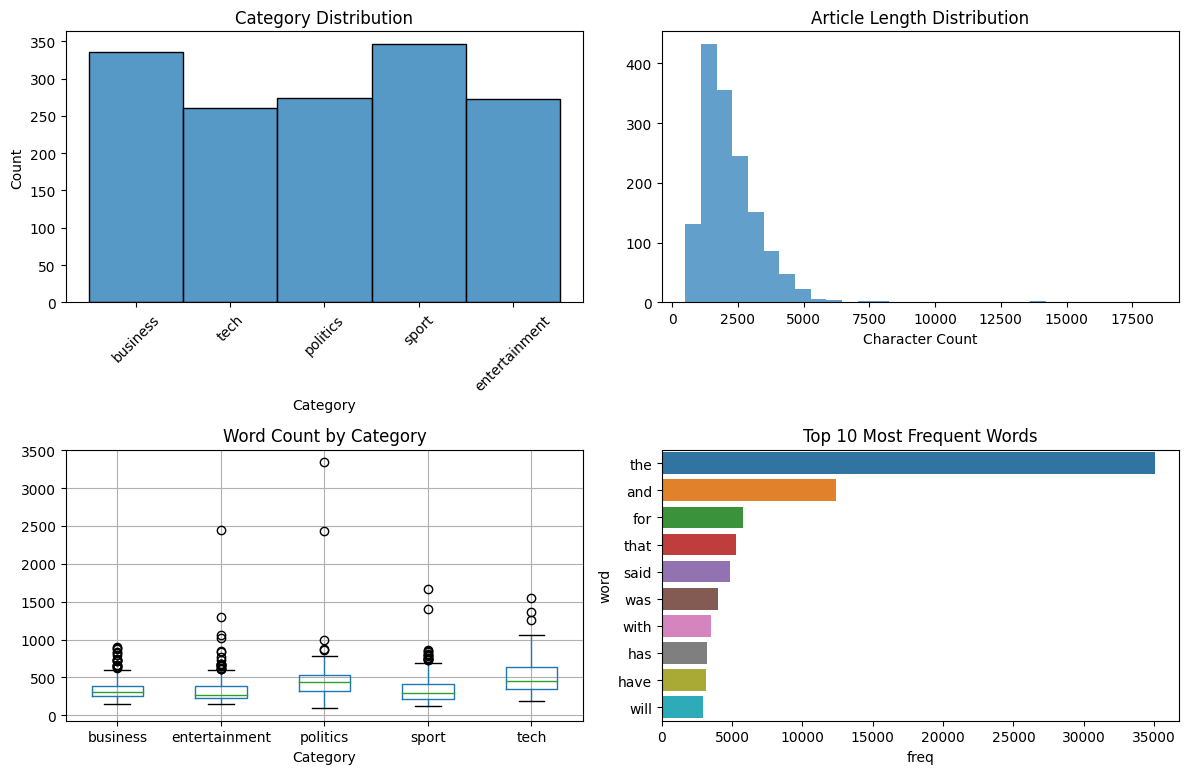


=== TEXT STATISTICS ===
Average article length: 2233 characters
Average word count: 385 words
               text_length  word_count
Category                              
business       1983.104167  334.169643
entertainment  1910.380952  333.912088
politics       2617.905109  449.689781
sport          1894.624277  335.346821
tech           2939.291188  501.858238


In [5]:
print("\n=== EDA: CATEGORY DISTRIBUTION ===")
print(train_data['Category'].value_counts())

# Visualization 1: Category histogram
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
sns.histplot(train_data, x="Category")
plt.title('Category Distribution')
plt.xticks(rotation=45)

# Text length analysis
train_data['text_length'] = train_data['Text'].str.len()
train_data['word_count'] = train_data['Text'].str.split().str.len()

plt.subplot(2, 2, 2)
plt.hist(train_data['text_length'], bins=30, alpha=0.7)
plt.title('Article Length Distribution')
plt.xlabel('Character Count')

plt.subplot(2, 2, 3)
train_data.boxplot(column='word_count', by='Category', ax=plt.gca())
plt.title('Word Count by Category')
plt.suptitle('')

# Most common words analysis
all_text = ' '.join(train_data['Text']).lower()
words = re.findall(r'\b[a-zA-Z]{3,}\b', all_text)
word_freq = Counter(words).most_common(15)
words_df = pd.DataFrame(word_freq, columns=['word', 'freq'])

plt.subplot(2, 2, 4)
sns.barplot(data=words_df.head(10), x='freq', y='word')
plt.title('Top 10 Most Frequent Words')

plt.tight_layout()
plt.show()

print("\n=== TEXT STATISTICS ===")
print(f"Average article length: {train_data['text_length'].mean():.0f} characters")
print(f"Average word count: {train_data['word_count'].mean():.0f} words")
print(train_data.groupby('Category')[['text_length', 'word_count']].mean())

In [13]:
# Check duplicates
print(f"\nDuplicates: {train_data.duplicated().sum()}")
train_data = train_data.drop_duplicates(subset=["Text"]).reset_index(drop=True)
print(f"After removing duplicates: {len(train_data)} articles")


Duplicates: 0
After removing duplicates: 1440 articles


# **Preprocessing**

In [16]:
def preprocess_text(text):
    """
    Text preprocessing pipeline:
    1) Lowercase conversion
    2) Remove numbers and punctuation  
    3) Remove extra whitespace
    """
    text = text.lower()
    text = re.sub(r'\d+', '', text)  # Remove numbers
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    text = ' '.join(text.split())  # Remove extra whitespace
    return text

print("\n=== TEXT PREPROCESSING ===")
train_data['processed_text'] = train_data['Text'].apply(preprocess_text)
test_data['processed_text'] = test_data['Text'].apply(preprocess_text)

# Show preprocessing example
print("Original:", train_data['Text'].iloc[0][:100])
print("Processed:", train_data['processed_text'].iloc[0][:100])




=== TEXT PREPROCESSING ===
Original: worldcom ex-boss launches defence lawyers defending former worldcom chief bernie ebbers against a ba
Processed: worldcom exboss launches defence lawyers defending former worldcom chief bernie ebbers against a bat


**TF-IDF FEATURE EXTRACTION**

In [14]:
print("\n=== TF-IDF VECTORIZATION ===")
print("""
TF-IDF (Term Frequency-Inverse Document Frequency) explanation:
- TF: How often a word appears in a document (local importance)
- IDF: How rare a word is across all documents (global importance)  
- TF-IDF = TF × IDF balances frequent vs distinctive words
""")

# KEY DECISION: Include test data in TF-IDF fitting for better topic discovery
print("DECISION: Including test text in TF-IDF (unsupervised approach)")
all_texts = pd.concat([train_data['processed_text'], test_data['processed_text']])

vectorizer = TfidfVectorizer(max_features=5000, max_df=0.9, stop_words="english")
X_all_tfidf = vectorizer.fit_transform(all_texts)

# Split back to train/test
X_train_tfidf = X_all_tfidf[:len(train_data)]
X_test_tfidf = X_all_tfidf[len(train_data):]

print(f"TF-IDF matrix shape: {X_train_tfidf.shape}")

# Show top TF-IDF words by category
feature_names = vectorizer.get_feature_names_out()
print("\n=== TOP TF-IDF WORDS BY CATEGORY ===")
for category in train_data['Category'].unique():
    cat_indices = train_data[train_data['Category'] == category].index
    cat_tfidf = X_train_tfidf[cat_indices].mean(axis=0).A1
    top_indices = cat_tfidf.argsort()[-5:][::-1]
    top_words = [feature_names[i] for i in top_indices]
    print(f"{category}: {', '.join(top_words)}")



=== TF-IDF VECTORIZATION ===

TF-IDF (Term Frequency-Inverse Document Frequency) explanation:
- TF: How often a word appears in a document (local importance)
- IDF: How rare a word is across all documents (global importance)  
- TF-IDF = TF × IDF balances frequent vs distinctive words

DECISION: Including test text in TF-IDF (unsupervised approach)
TF-IDF matrix shape: (1440, 5000)

=== TOP TF-IDF WORDS BY CATEGORY ===
business: bn, said, growth, economy, firm
tech: people, said, mobile, software, users
politics: mr, said, labour, blair, election
sport: england, game, win, said, cup
entertainment: film, best, music, said, band


# **MATRIX FACTORIZATION**


Testing NMF with 5 components...
NMF (5 components) accuracy: 0.9139

Testing NMF with 7 components...


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


NMF (7 components) accuracy: 0.6090

Testing NMF with 10 components...


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


NMF (10 components) accuracy: 0.5785

Best NMF: 5 components, accuracy: 0.9139

=== COMPARING WITH SVD ===
SVD accuracy: 0.3812
NMF vs SVD: NMF wins


<Figure size 800x600 with 0 Axes>

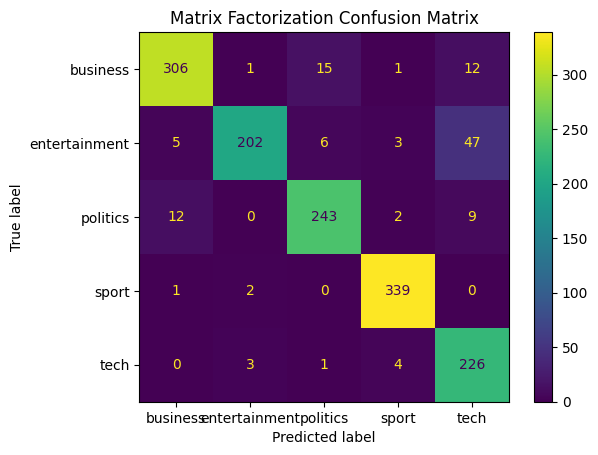

In [17]:
# Helper function for label permutation (since unsupervised)
def label_permute_compare(y_true, y_pred, categories=["business", "entertainment", "politics", "sport", "tech"]):
    permutation_list = list(itertools.permutations(categories))
    y_pred_df = pd.DataFrame(data=y_pred)
    
    best_acc = 0
    best_order = None
    
    for perm in permutation_list:
        y_pred_mapped = y_pred_df.replace([0,1,2,3,4], perm)
        acc = accuracy_score(y_true, y_pred_mapped)
        if acc > best_acc:
            best_acc = acc
            best_order = perm
    
    return best_order, best_acc

# Test different numbers of components
component_options = [5, 7, 10]
nmf_results = {}

for n_comp in component_options:
    print(f"\nTesting NMF with {n_comp} components...")
    
    # NMF
    nmf = NMF(n_components=n_comp, random_state=42)
    W_train = nmf.fit_transform(X_train_tfidf)
    
    if n_comp == 5:  # Direct mapping
        y_pred_nmf = W_train.argmax(axis=1)
    else:  # Use clustering for mapping
        from sklearn.cluster import KMeans
        kmeans = KMeans(n_clusters=5, random_state=42)
        y_pred_nmf = kmeans.fit_predict(W_train)
    
    # Find best label mapping
    perm_nmf, acc_nmf = label_permute_compare(train_data['Category'], y_pred_nmf)
    nmf_results[n_comp] = {'model': nmf, 'accuracy': acc_nmf, 'permutation': perm_nmf}
    
    print(f"NMF ({n_comp} components) accuracy: {acc_nmf:.4f}")

# Select best NMF model
best_n_comp = max(nmf_results.keys(), key=lambda k: nmf_results[k]['accuracy'])
best_nmf = nmf_results[best_n_comp]
print(f"\nBest NMF: {best_n_comp} components, accuracy: {best_nmf['accuracy']:.4f}")

# Compare with SVD
print("\n=== COMPARING WITH SVD ===")
svd = TruncatedSVD(n_components=5, algorithm="arpack")
W_svd = svd.fit_transform(X_train_tfidf)
y_pred_svd = W_svd.argmax(axis=1)
perm_svd, acc_svd = label_permute_compare(train_data['Category'], y_pred_svd)

print(f"SVD accuracy: {acc_svd:.4f}")
print(f"NMF vs SVD: NMF {'wins' if best_nmf['accuracy'] > acc_svd else 'loses'}")

# Confusion Matrix for best model
y_pred_mapped = pd.DataFrame(best_nmf['model'].transform(X_train_tfidf).argmax(axis=1))
y_pred_final = y_pred_mapped.replace([0,1,2,3,4], best_nmf['permutation'])

plt.figure(figsize=(8, 6))
ConfusionMatrixDisplay.from_predictions(train_data['Category'], y_pred_final)
plt.title('Matrix Factorization Confusion Matrix')
plt.show()


# **SUPERVISED LEARNING COMPARISON**


--- Testing with 10% of training data ---
SVM accuracy: 0.9271
Random Forest accuracy: 0.7812
Matrix Factorization (constant): 0.9139

--- Testing with 20% of training data ---
SVM accuracy: 0.9444
Random Forest accuracy: 0.7882
Matrix Factorization (constant): 0.9139

--- Testing with 50% of training data ---
SVM accuracy: 0.9583
Random Forest accuracy: 0.8090
Matrix Factorization (constant): 0.9139

--- Testing with 100% of training data ---
SVM accuracy: 0.9653
Random Forest accuracy: 0.8368
Matrix Factorization (constant): 0.9139


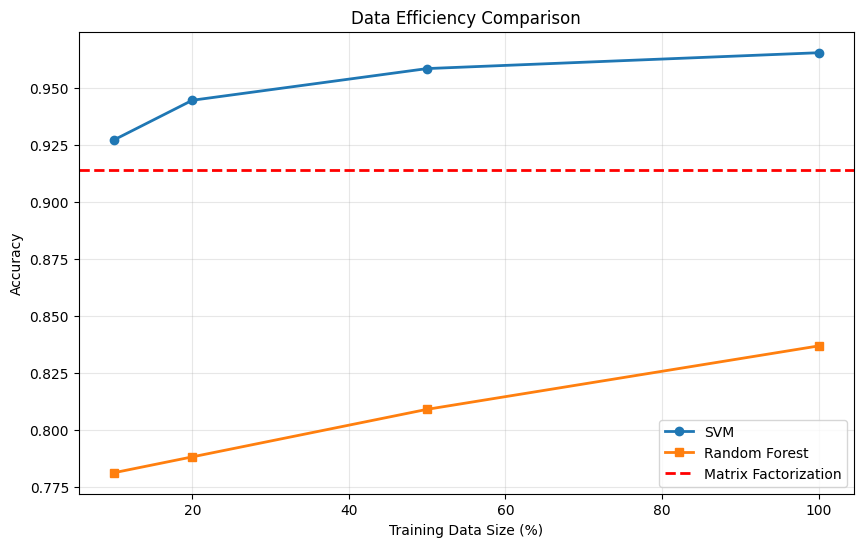

In [18]:
# Split for supervised learning
X_train_sup, X_val_sup, y_train_sup, y_val_sup = train_test_split(
    X_train_tfidf, train_data['Category'], test_size=0.2, random_state=42, stratify=train_data['Category']
)

# Test different data sizes
data_sizes = [0.1, 0.2, 0.5, 1.0]
supervised_results = {}

for size in data_sizes:
    print(f"\n--- Testing with {int(size*100)}% of training data ---")
    
    if size < 1.0:
        X_subset, _, y_subset, _ = train_test_split(
            X_train_sup, y_train_sup, train_size=size, random_state=42, stratify=y_train_sup
        )
    else:
        X_subset, y_subset = X_train_sup, y_train_sup
    
    # Linear SVM
    svm = LinearSVC(class_weight="balanced", loss="squared_hinge", max_iter=5000)
    svm.fit(X_subset, y_subset)
    svm_acc = svm.score(X_val_sup, y_val_sup)
    
    # Random Forest  
    rf = RandomForestClassifier(criterion='gini', max_depth=4, n_estimators=100)
    rf.fit(X_subset, y_subset)
    rf_acc = rf.score(X_val_sup, y_val_sup)
    
    supervised_results[size] = {'svm': svm_acc, 'rf': rf_acc}
    print(f"SVM accuracy: {svm_acc:.4f}")
    print(f"Random Forest accuracy: {rf_acc:.4f}")
    print(f"Matrix Factorization (constant): {best_nmf['accuracy']:.4f}")

# Visualization: Data efficiency comparison
plt.figure(figsize=(10, 6))
sizes = list(supervised_results.keys())
svm_accs = [supervised_results[s]['svm'] for s in sizes]
rf_accs = [supervised_results[s]['rf'] for s in sizes]

plt.plot([s*100 for s in sizes], svm_accs, 'o-', label='SVM', linewidth=2)
plt.plot([s*100 for s in sizes], rf_accs, 's-', label='Random Forest', linewidth=2)
plt.axhline(y=best_nmf['accuracy'], color='red', linestyle='--', label='Matrix Factorization', linewidth=2)

plt.xlabel('Training Data Size (%)')
plt.ylabel('Accuracy')
plt.title('Data Efficiency Comparison')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


# **Use best performing model for final predictions**

In [20]:

best_supervised_acc = max(supervised_results[1.0]['svm'], supervised_results[1.0]['rf'])
method_name = 'SVM' if supervised_results[1.0]['svm'] > supervised_results[1.0]['rf'] else 'Random Forest'

if best_nmf['accuracy'] > best_supervised_acc:
    print(f"Using Matrix Factorization (accuracy: {best_nmf['accuracy']:.4f})")
    
    # Predict on test data
    W_test = best_nmf['model'].transform(X_test_tfidf)
    test_predictions = W_test.argmax(axis=1)
    test_pred_df = pd.DataFrame(test_predictions)
    test_categories = test_pred_df.replace([0,1,2,3,4], best_nmf['permutation'])
    
else:
    print(f"Using {method_name} (accuracy: {best_supervised_acc:.4f})")
    
    # Retrain best supervised model on full data
    if method_name == 'SVM':
        final_model = LinearSVC(class_weight="balanced", loss="squared_hinge", max_iter=5000)
    else:
        final_model = RandomForestClassifier(criterion='gini', max_depth=4, n_estimators=100)
    
    final_model.fit(X_train_tfidf, train_data['Category'])
    test_categories = final_model.predict(X_test_tfidf)

# Create submission
submission = pd.DataFrame({
    'ArticleId': test_data['ArticleId'],
    'Category': test_categories.iloc[:,0] if hasattr(test_categories, 'iloc') else test_categories
})

submission.to_csv('bbc_submission.csv', index=False)
print("Submission saved as 'bbc_submission.csv'")
print(submission['Category'].value_counts())


Using SVM (accuracy: 0.9653)
Submission saved as 'bbc_submission.csv'
Category
business         171
sport            166
politics         143
tech             138
entertainment    117
Name: count, dtype: int64
